In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
random_state = 42
tf.random.set_seed(random_state)
n_features = 63

In [3]:
rfe_sel = ['P_VSA_MR_5', 'Mor22s', 'Mor04m', 'LUMO / eV', 'E1p', 'HOMO / eV', 'P_VSA_LogP_2', 'Mor29v', 'MATS5v',
           'Mor14s', 'Mor14u', 'CATS3D_02_AP', 'GATS5v', 'MATS5m', 'GATS2s', 'Mor32m', 'H3m', 'TDB04s', 'E2s', 'R5p+',
           'R2e+', 'ISH', 'DISPm', 'R5i+', 'Mor04i', 'Ds', 'Mor03s', 'E2m', 'Mor28s', 'Mor11u', 'TDB03m', 'Mor19m',
           'VE2sign_G', 'SpMAD_RG', 'R3s+', 'R5e+', 'E2v', 'Mor15i', 'T(N..O)', 'R2u+', 'MATS8p', 'Eta_epsi_5',
           'MATS4s', 'H0v', 'Hy', 'E1i', 'VE1sign_G', 'Mor15s', 'E3e', 'Mor13u', 'Eig03_AEA(dm)', 'X4Av', 'P_VSA_e_3',
           'Mor29e', 'Mor16m', 'GATS5m', 'E3p', 'E2e', 'X3Av', 'Mor19u', 'GATS4s', 'E3v', 'TDB04m']

In [4]:
data = pd.read_csv('..\\Data\\ze41_mol_desc_db_red.csv', header=0, sep=';', decimal=',')

In [5]:
col_names = data.columns
X = data[rfe_sel[:n_features]].astype('float32')
#X = data[col_names[3:]].astype('float32')
y = data[col_names[1]].astype('float32')

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=random_state)
[X_train, X_valid, y_train, y_valid] = [pd.DataFrame(x) for x in [X_train, X_valid, y_train, y_valid]]

In [7]:
scalex = MinMaxScaler(feature_range=(-1,1))
scalex.fit(X_train)
[X_train_sc, X_valid_sc] = [pd.DataFrame(scalex.transform(x), columns=X.columns) for x in [X_train, X_valid]]

In [8]:
scaley = MinMaxScaler(feature_range=(0, 1))
scaley.fit(y_train)
[y_train_sc, y_valid_sc] = [pd.DataFrame(scaley.transform(y), columns=y.columns) for y in [y_train, y_valid]]

In [9]:
class Autoencoder(keras.models.Model):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            #keras.layers.Dense(150, activation='linear'),
            #keras.layers.LeakyReLU(),
            keras.layers.Dense(latent_dim, activation='linear'),
            keras.layers.LeakyReLU(),
        ])
        self.decoder = tf.keras.Sequential([
            #keras.layers.Dense(150, activation='linear'),
            #keras.layers.LeakyReLU(),
            keras.layers.Dense(len(X_train.columns), activation='linear')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
autoencoder = Autoencoder(latent_dim=2)

In [11]:
autoencoder.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [12]:
history = autoencoder.fit(X_train_sc, X_train_sc, validation_data=(X_valid_sc, X_valid_sc), epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 47ms/step - loss: 0.3196 - val_loss: 0.3344
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2982 - val_loss: 0.3243
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2847 - val_loss: 0.3118
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2719 - val_loss: 0.2963
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2573 - val_loss: 0.2792
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2423 - val_loss: 0.2628
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2287 - val_loss: 0.2499
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2167 - val_loss: 0.2393
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2047 - val_loss: 0.2305
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1937 - val_loss: 0.2244
Epoch 11/100
2/2 [==========

2/2 [==============================] - 0s 8ms/step - loss: 0.1196 - val_loss: 0.1788
Epoch 84/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1195 - val_loss: 0.1789
Epoch 85/100
2/2 [==============================] - ETA: 0s - loss: 0.123 - 0s 8ms/step - loss: 0.1195 - val_loss: 0.1789
Epoch 86/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1194 - val_loss: 0.1792
Epoch 87/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1194 - val_loss: 0.1792
Epoch 88/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1193 - val_loss: 0.1793
Epoch 89/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1192 - val_loss: 0.1794
Epoch 90/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1192 - val_loss: 0.1793
Epoch 91/100
2/2 [==============================] - ETA: 0s - loss: 0.125 - 0s 8ms/step - loss: 0.1191 - val_loss: 0.1792
Epoch 92/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1190 - va

In [13]:
encoded = autoencoder.encoder(X_valid_sc.to_numpy()).numpy()

In [14]:
np.min(encoded, axis=0), np.mean(encoded, axis=0), np.max(encoded, axis=0)

(array([-1.4604414 , -0.26159322], dtype=float32),
 array([-1.0359095 ,  0.77694803], dtype=float32),
 array([-0.17236677,  1.6921577 ], dtype=float32))

In [15]:
np.where(np.all(np.isclose(encoded, 0), axis=0))[0]

array([], dtype=int64)

In [16]:
encoded

array([[-0.17236677,  1.6921577 ],
       [-1.3956571 ,  1.2397519 ],
       [-0.88438344,  0.3551527 ],
       [-1.137145  ,  1.2636604 ],
       [-1.4604414 , -0.26159322],
       [-1.1654637 ,  0.37255907]], dtype=float32)

In [17]:
encoded.shape

(6, 2)

In [18]:
enc_train = autoencoder.encoder(X_train_sc.to_numpy()).numpy()

In [19]:
enc_train.shape

(54, 2)

In [20]:
X_v_enc = pd.DataFrame(encoded, columns=['enc_dim_1', 'enc_dim_2'], index=X_valid.index)

In [21]:
X_t_enc = pd.DataFrame(enc_train, columns=['enc_dim_1', 'enc_dim_2'], index=X_train.index)

In [22]:
X_enc = X_t_enc.append(X_v_enc)

In [23]:
data[X_enc.columns] = X_enc.sort_index()

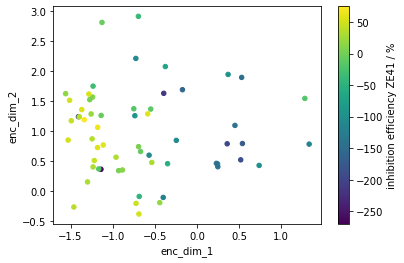

In [24]:
fig, ax = plt.subplots()
data.plot.scatter(x='enc_dim_1', y='enc_dim_2', c = 'inhibition efficiency ZE41 / %', ax=ax, colormap='viridis')
plt.show()

In [25]:
data.head()

,compound,inhibition efficiency ZE41 / %,LinIE ZE41,MW,AMW,Mv,Mi,nTA,RBF,nDB,...,CATS3D_04_LL,CATS3D_05_LL,HOMO / eV,LUMO / eV,Hlgap / eV,Cv / kJ/(mol-K)@293.15K,Cp / kJ/(mol-K)@293.15K,chem_pot / kJ/mol@293.15K,enc_dim_1,enc_dim_2
0,3-Amino-124-triazole,-157,0.328,84.10,8.410,0.609,1.199,1.0,0.000,0.0,...,0.0,0.0,-5.422,0.078,5.500,0.074309,0.082623,127.67,-0.172367,1.692158
1,3-methylcatechol,-31,0.693,124.15,7.303,0.620,1.122,3.0,0.000,0.0,...,1.0,0.0,-5.311,-0.184,5.127,0.135196,0.143511,269.94,-1.232688,1.752090
2,3-methylsalicylicacid,75,1.000,152.16,8.008,0.645,1.120,4.0,0.053,1.0,...,1.0,0.0,-5.870,-1.812,4.058,0.151551,0.159865,296.04,-1.337910,1.192940
3,4-aminosalicylicacid,57,0.948,153.15,8.508,0.653,1.132,4.0,0.056,1.0,...,0.0,0.0,-5.545,-1.331,4.215,0.152926,0.161240,267.85,-1.180406,0.728943
4,4-hydroxybenzoicacid,-170,0.290,138.13,8.633,0.670,1.117,3.0,0.063,1.0,...,0.0,0.0,-6.198,-1.472,4.726,0.132298,0.140612,225.54,-1.405972,1.243236


In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation='relu', input_shape=(len(X.columns),)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

In [27]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error')

In [28]:
dec_train = autoencoder.decoder(enc_train)
dec_valid = autoencoder.decoder(encoded)

In [29]:
#[dec_train, dec_valid] = [pd.DataFrame(x, columns = X.columns) for x in [dec_train, dec_valid]]
#[dec_train, dec_valid] = [np.asarray(x).astype('float32') for x in [dec_train, dec_valid]]

In [30]:
history = model.fit(dec_train, y_train_sc, validation_data=(dec_valid, y_valid_sc), epochs=25)

Epoch 1/25
2/2 [==============================] - 0s 39ms/step - loss: 0.4221 - val_loss: 0.1831
Epoch 2/25
2/2 [==============================] - 0s 8ms/step - loss: 0.1319 - val_loss: 0.0323
Epoch 3/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0802 - val_loss: 0.1079
Epoch 4/25
2/2 [==============================] - 0s 8ms/step - loss: 0.1077 - val_loss: 0.0302
Epoch 5/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0413 - val_loss: 0.0168
Epoch 6/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0504 - val_loss: 0.0375
Epoch 7/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0682 - val_loss: 0.0247
Epoch 8/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0529 - val_loss: 0.0068
Epoch 9/25
2/2 [==============================] - 0s 8ms/step - loss: 0.0366 - val_loss: 0.0159
Epoch 10/25
2/2 [==============================] - 0s 0s/step - loss: 0.0406 - val_loss: 0.0288
Epoch 11/25
2/2 [======================

In [31]:
grid_x = np.linspace(X_enc['enc_dim_1'].min(), X_enc['enc_dim_1'].max(), 101)
grid_y = np.linspace(X_enc['enc_dim_2'].min(), X_enc['enc_dim_2'].max(), 101)
#grid_coords = np.linspace(-1, 1, 101)
xv, yv = np.meshgrid(grid_x, grid_y)

In [32]:
positions = np.transpose(np.vstack([xv.ravel(), yv.ravel()]))

In [33]:
grid_dec = autoencoder.decoder(positions)
grid_pred = model.predict(grid_dec)
grid_pred = scaley.inverse_transform(grid_pred)

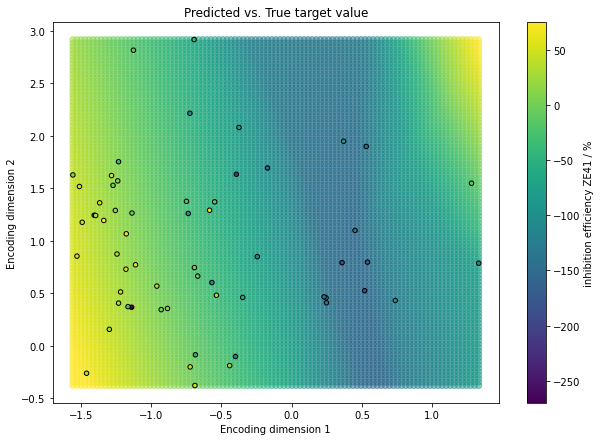

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
p1 = ax.scatter(xv.ravel(), yv.ravel(), c=grid_pred, alpha=0.5, vmin=-270, vmax=75)
data.plot.scatter(x='enc_dim_1', y='enc_dim_2', c = 'inhibition efficiency ZE41 / %', ax=ax,
                  colormap='viridis', edgecolors='black')
ax.set_title('Predicted vs. True target value')
ax.set_xlabel('Encoding dimension 1')
ax.set_ylabel('Encoding dimension 2')
plt.show()